In [ ]:
#!unzip "/content/drive/MyDrive/MY WORK/Copy of 50_Speakers.zip" -d "/content/drive/MyDrive/50_speaker"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
#Dataset link-https://www.kaggle.com/datasets/vjcalling/speaker-recognition-audio-dataset

In [4]:
audio_loc=[]
labels=[]
speakers_folders=os.listdir("/content/drive/MyDrive/50_speaker/archive/50_speakers_audio_data")
for folder in speakers_folders:
    
    audio_files=os.listdir("/content/drive/MyDrive/50_speaker/archive/50_speakers_audio_data/"+folder)
    for audio in audio_files:
        audio_loc.append("/content/drive/MyDrive/50_speaker/archive/50_speakers_audio_data/"+folder+'/'+audio)
        if '_' in folder:
            labels.append(folder.split('_')[1])
        else:
            labels.append(folder[7:])

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
new_labels=le.transform(labels)
new_labels=list(new_labels)

In [6]:
data = pd.DataFrame(list(zip(audio_loc,new_labels)),columns =['File Location','Labels'])

In [7]:
data.head()

,File Location,Labels
0,/content/drive/MyDrive/50_speaker/archive/50_s...,40
1,/content/drive/MyDrive/50_speaker/archive/50_s...,40
2,/content/drive/MyDrive/50_speaker/archive/50_s...,40
3,/content/drive/MyDrive/50_speaker/archive/50_s...,40
4,/content/drive/MyDrive/50_speaker/archive/50_s...,40


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['File Location'],new_labels,stratify=new_labels,test_size=0.20)

In [ ]:
#mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

In [9]:
audio=data['File Location'][0]

In [10]:
audio

'/content/drive/MyDrive/50_speaker/archive/50_speakers_audio_data/Speaker0041/Speaker0041_004.wav'

In [11]:
signal, sample_rate = librosa.load(audio, sr=22050,duration=2)
hop_length=512
#sgram_mag, _ = librosa.magphase(signal)

In [12]:
mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)

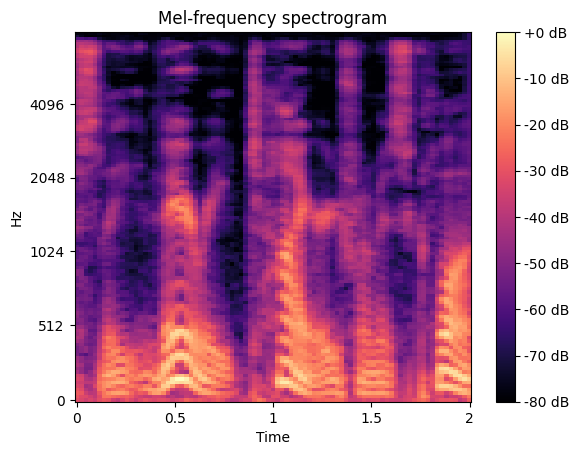

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#Transforming the amplitude to decibel
S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
fig.savefig('spectrogram.jpg', dpi=300, bbox_inches='tight')

In [14]:
S_dB.shape

(128, 87)

In [15]:
# Get mel spectrograms

def mel_spectrogram_gen(audio):
    signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
    hop_length=512
    mel_spectogram=librosa.feature.melspectrogram(signal,sample_rate,hop_length=hop_length)
    S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
    
    return S_dB



In [16]:
#Getting mel spectograms for all the audio clips in the train data

X_train_mel=[]

hop_length=512

for audio in X_train:
    signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
    hop_length=512
    mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)
    S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
    X_train_mel.append(S_dB)
    
    

In [17]:
rows=[]
columns=[]

for mel in X_train_mel:
    rows.append(mel.shape[0])
    columns.append(mel.shape[1])

In [18]:
#Getting max pad length

max_pad_len=np.max(columns)

In [19]:
max_pad_len

130

In [20]:
#Padding all the mel spectograms
X_train_mel_padded=[]

for mel in X_train_mel:
    padded_mel=np.pad(mel,((0,0),(0,max_pad_len-mel.shape[1])),'constant',constant_values=0)
    X_train_mel_padded.append(padded_mel)
    
X_train_mel_padded=np.array(X_train_mel_padded)
X_train_mel_padded=X_train_mel_padded/255

In [21]:
#Getting mel spectograms for all the audio clips in the test data

X_test_mel=[]


for audio in X_test:
    signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
    hop_length=512
    mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)
    S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
    X_test_mel.append(S_dB)

In [22]:
#Padding all the mel spectrograms in test data

X_test_mel_padded=[]

for mel in X_test_mel:
    if mel.shape[1]<max_pad_len:
        padded_mel=np.pad(mel,((0,0),(0,max_pad_len-mel.shape[1])),'constant',constant_values=0)
    else:
        padded_mel=mel[:,:max_pad_len]
    X_test_mel_padded.append(padded_mel)
    
X_test_mel_padded=np.array(X_test_mel_padded)
X_test_mel_padded=X_test_mel_padded/255

In [23]:

# making positive & negative image pairs

def make_pairs(images, labels):
      
      labels=np.array(labels)
      # initialize two empty lists to hold the (image, image) pairs and
      # labels to indicate if a pair is positive or negative
      pairImages = []
      pairLabels = []

      numClasses = len(np.unique(labels)) # find all unique class labels
     
      # idxs -> list of all indexes that belong to the current class label i
      idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
     
      # loop over all images
      for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label =labels[idxA]
        # randomly pick an image that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label i.e., idx of negative pair image
        negIdx = np.where(labels != label)[0]
        # images corresponding to negIdx
        negImage = images[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
        # return a 2-tuple of our image pairs and labels
        # i.e., 
      return (np.array(pairImages), np.array(pairLabels))

In [24]:
# add a channel dimension to the images

X_train_mel_padded = np.expand_dims(X_train_mel_padded, axis=-1)
X_test_mel_padded = np.expand_dims(X_test_mel_padded, axis=-1)

In [25]:
#Making Data Pair for Train Data
Pair_train,Label_train=make_pairs(X_train_mel_padded,y_train)

In [26]:
#Making Data Pair for Test Data

Pair_test,Label_test=make_pairs(X_test_mel_padded,y_test)

In [27]:
Pair_train.shape

(4016, 2, 128, 130, 1)

# Building Siamese Network

In [28]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
def build_siamese_model(inputShape, embeddingDim=48):
  # specify the inputs for the feature extractor network
  inputs = Input(inputShape)
  # define the first set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu",kernel_initializer=tf.keras.initializers.he_normal(seed=0))(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)
  # second set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu",kernel_initializer=tf.keras.initializers.he_normal(seed=0))(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.2)(x)
  BatchNorm = tf.keras.layers.BatchNormalization()(x)
  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(BatchNorm)
  outputs = Dense(embeddingDim)(pooledOutput) # output dense layer
  # build the model
  model = Model(inputs, outputs)
  # return the model to the calling function
  return model

In [30]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [31]:
max_pad_len=130

In [32]:
# specify the shape of the inputs for our network
IMG_SHAPE = (128,max_pad_len, 1)
# specify the batch size and number of epochs
BATCH_SIZE =64
EPOCHS =500

In [33]:
architecture = build_siamese_model(inputShape=IMG_SHAPE, embeddingDim=48)

In [34]:
architecture.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 130, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 130, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 65, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 65, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 65, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                         

In [35]:
tf.keras.backend.clear_session()
import random as rn
## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [36]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [37]:
# compiling the model
#opt=tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
#opt =tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [ ]:
# Saving the model

from tensorflow.keras.callbacks import ModelCheckpoint 
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max') 

#LrOnPlateau scheduler 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5,min_lr=0.001)


In [ ]:
#history = model.fit([Pair_train[:, 0], Pair_train[:, 1]], Label_train[:],validation_data=([Pair_test[:, 0], Pair_test[:, 1]], Label_test[:]),batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/500
63/63 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.61730, saving model to model_save/weights-01-0.6173.hdf5
63/63 [==============================] - 27s 140ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6886 - val_accuracy: 0.6173
Epoch 2/500
63/63 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.61730 to 0.65308, saving model to model_save/weights-02-0.6531.hdf5
63/63 [==============================] - 7s 119ms/step - loss: 0.6867 - accuracy: 0.5000 - val_loss: 0.6826 - val_accuracy: 0.6531
Epoch 3/500
63/63 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.5027
Epoch 3: val_accuracy improved from 0.65308 to 0.69284, saving model to model_save/weights-03-0.6928.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 0.6766 - accuracy: 0.5027 - val_loss: 0.6789 - val_accuracy: 0.6928
Epoch 

In [42]:
#Loading the model
model.load_weights("/content/weights-333-0.9394.hdf5")

In [43]:
from sklearn.metrics import classification_report

# predict on test data
y_pred = model.predict([Pair_test[:, 0], Pair_test[:, 1]])

# Convert the probabilities to binary predictions using a threshold
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)
print(y_pred)
# Generate a classification report
target_names = ['Negative', 'Positive']
print(classification_report(Label_test, y_pred, target_names=target_names))

32/32 [==============================] - 0s 11ms/step
[[1]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]
              precision    recall  f1-score   support

    Negative       0.99      0.90      0.94       503
    Positive       0.91      0.99      0.95       503

    accuracy                           0.95      1006
   macro avg       0.95      0.95      0.95      1006
weighted avg       0.95      0.95      0.95      1006



In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

# predict on test data
y_pred = model.predict([Pair_test[:, 0], Pair_test[:, 1]]) #produces similarity score- 0.98 indicated 98% the two audios are similar.

# Convert the probabilities to binary predictions using a threshold
threshold = 0.5 #because the similarity score ranges between 0 and 1, and 0.5 is the midpoint of this range
y_pred = np.where(y_pred > threshold, 1, 0)

# Calculate evaluation metrics
accuracy = accuracy_score(Label_test, y_pred)
precision = precision_score(Label_test, y_pred)
recall = recall_score(Label_test, y_pred)
f1 = f1_score(Label_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


32/32 [==============================] - 0s 9ms/step
Accuracy: 0.9473161033797217
Precision: 0.9120879120879121
Recall: 0.9900596421471173
F1 score: 0.9494756911344138


32/32 [==============================] - 0s 11ms/step


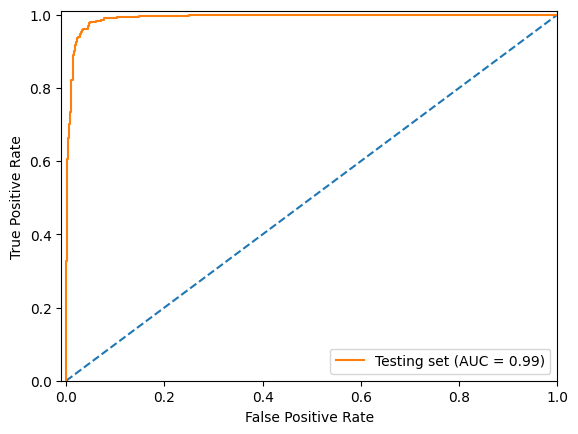

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

# predict on test data
y_pred_prob = model.predict([Pair_test[:, 0], Pair_test[:, 1]])

# calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(Label_test, y_pred_prob)

# calculate AUC
roc_auc = roc_auc_score(Label_test, y_pred_prob)

# plot ROC curve
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='Testing set (AUC = %0.2f)' % roc_auc)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import the necessary packages
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import nlpaug.augmenter.audio as naa



import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
## METAMORPHIC TESTING
#Creating a function for augmenting the data with noise.
 
def RMS(audio_signal):
    RMS=math.sqrt(np.mean(audio_signal**2))
    return RMS

def RMS_noise_required(audio_signal,required_SNR):
    RMS_n=(RMS(audio_signal)/(10**required_SNR))
    return RMS_n    

def Audio_Augmenter(Noise_Loc,Required_SNR):
    # Defining the functiom to calculate RMS and required RMS value of noise as 
    # per Signal to Noise Ratio(SNR).
    
    # Adding traffic noise as background noise.

    noise, sample_rate1 = librosa.load(Noise_Loc)

    #Setting SNR of the noise as required

    noise_snr=noise*(RMS_noise_required(noise,Required_SNR)/RMS(noise))

    #Creating object for augmentation
    
    coverage=np.random.rand(1)

    aug = naa.NoiseAug(zone=(0.2,0.8),coverage=coverage,noises=[noise_snr])
    
    return(aug)



In [ ]:
#Defining function for metamorphic testing
from skimage.transform import resize
def metamorphic_testing(MR,Test_Data_Loc,Labels):
    
    scores=[]
    
    mr_violations_list=[]
    
    if MR=='Loudness':
        
        loudness_list=input('Enter the values of loudness for testing. Values should be a tuple and tuples should be seperated by ";"')
        tuple_list=[]

        for i in loudness_list.split(';'):
            num_list=[]
            num_list.append(float(i[1]))
            num_list.append(float(i[3]))
            tuple_list.append(tuple(num_list))
        Factor_List=tuple_list
        
    if MR=='Noise':
            
        snr_str_list=input('Enter the values of SNR for testing')
            
        snr_list=[]
            
        snr_values=snr_str_list.split(',')
            
        for snr_value in snr_values:
            snr_list.append(float(snr_value))
            
        Factor_List=snr_list
            
        Noise_Loc=input("Enter the file location of the noise")
        
    if MR=='Pitch':
        
        pitch_list=input('Enter the values of pitch for testing. Values should be a tuple and tuples should be seperated by ";"')
        tuple_list=[]

        for i in pitch_list.split(';'):
            num_list=[]
            num_list.append(float(i[1]))
            num_list.append(float(i[3]))
            tuple_list.append(tuple(num_list))
        Factor_List=tuple_list

    if MR=='trim':
        top_db = input('Enter the values of SNR for testing')
        db_list=[]
            
        db_values=top_db.split(',')
            
        for db_value in db_values:
            db_list.append(float(db_value))
            
        Factor_List=db_list
    
    if MR=='time stretch':
        rate = input('Enter the values of SNR for testing')
        rate_list=[]
            
        rate_values=rate.split(',')
            
        for rate_value in rate_values:
            rate_list.append(float(rate_value))
            
        Factor_List=rate_list

    
    #Getting mel spectograms for all the audio clips in the original test data and evaluating it.
    
    X_test=Test_Data_Loc

    X_test_org=[]

    for audio in X_test:
        signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
        hop_length=512
        mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)
        S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
        S_dB_resized = resize(S_dB, (128, 130), anti_aliasing=True)
        X_test_org.append(S_dB_resized)
    X_test_org=np.array(X_test_org)

    # add a channel dimension to the images

    X_test_org=np.expand_dims(X_test_org, axis=-1)

    X_test_org=X_test_org/255.0
    
    #Making Data Pair for Clean Test Data 
    Pair_test_org,Label_test_org=make_pairs(X_test_org,Labels)
    
    
    acc=model.evaluate([Pair_test_org[:,0],Pair_test_org[:,1]],Label_test_org[:])[1]
    
    scores.append(acc)
    
    #Getting the indicies of the correctly classified points
    
    acc_org=model.predict([Pair_test_org[:,0],Pair_test_org[:,1]])
    
    y_pred_org=[]
    
    for i in range(acc_org.shape[0]):
        if acc_org[i]>0.5:
            y_pred_org.append(1)
        else:
            y_pred_org.append(0)
        
    correct_index=[]
    
    for i in range(len(y_pred_org)):
        if y_pred_org[i]==Label_test_org[i]:
            correct_index.append(i)
   
    
    #Evaluating the augmented data 
 
    for i in range(len(Factor_List)):
    
    
    
        #Getting mel spec for the augmented audioclips with traffic noise.SNR=0

    
        Factor=Factor_List[i]
        
        if MR=='Loudness':

            aug= naa.LoudnessAug(zone=(0.2, 0.8), coverage=1.0, factor=Factor)
            
        if MR=='Noise':
            
            aug=Audio_Augmenter(Noise_Loc,Factor)
            
        if MR=='Pitch':
            
            aug = naa.PitchAug(sampling_rate=sample_rate,factor=Factor)
            
            
        X_test_aug=[]

        index=0
        index_aug=0
        for audio in X_test:
            index=index+1
            p=np.random.rand(1)
            if p<0.2:
                if MR=='trim':
                   index_aug=index_aug+1
                   signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
                   augmented_data = librosa.effects.trim(y=signal,top_db=Factor)
                   hop_length=512
                   mel_spectogram=librosa.feature.melspectrogram(y=augmented_data[0],sr=sample_rate,hop_length=hop_length)
                   S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
                   S_dB_resized = resize(S_dB, (128, 130), anti_aliasing=True)
                   X_test_aug.append(S_dB_resized)

                elif MR=='time stretch':
                   index_aug=index_aug+1
                   signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
                   #signal_np = np.asarray(signal)
                   augmented_data = librosa.effects.time_stretch(y=signal, rate=Factor) 
                   hop_length=512
                   mel_spectogram=librosa.feature.melspectrogram(y=augmented_data,sr=sample_rate,hop_length=hop_length)
                   S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
                   S_dB_resized = resize(S_dB, (128, 130), anti_aliasing=True)
                   X_test_aug.append(S_dB_resized)
    
                elif MR=='Loudness' or MR=='Pitch' or MR=='Noise':
              
                   index_aug=index_aug+1
                   signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
                   #signal_np = np.asarray(signal)
                   augmented_data = aug.augment(signal)
                   hop_length=512
                   mel_spectogram=librosa.feature.melspectrogram(y=augmented_data[0],sr=sample_rate,hop_length=hop_length)
                   S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
                   S_dB_resized = resize(S_dB, (128, 130), anti_aliasing=True)
                   X_test_aug.append(S_dB_resized)
            else:
                signal, sample_rate = librosa.load(audio, sr=22050,duration=3)
                hop_length=512
                mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)
                S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
                S_dB_resized = resize(S_dB, (128, 130), anti_aliasing=True)
                X_test_aug.append(S_dB_resized)

        X_test_aug=np.array(X_test_aug)  

        # add a channel dimension to the images

        X_test_aug=np.expand_dims(X_test_aug, axis=-1)

        X_test_aug=X_test_aug/255
    
    
    

        #Making Data Pair for Augmented Test Data
        Pair_test_aug,Label_test_aug=make_pairs(X_test_aug,Labels)

        acc=model.evaluate([Pair_test_aug[:,0],Pair_test_aug[:,1]],Label_test_aug[:])[1]
        
        scores.append(acc)
        
        acc1=model.predict([Pair_test_aug[:,0],Pair_test_aug[:,1]])
        
        y_pred=[]

        for i in range(acc1.shape[0]):
            if acc1[i]>0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        
        
        false=[]
        for i in range(len(correct_index)):
            if y_pred[correct_index[i]]!=Label_test_aug[correct_index[i]]:
                false.append(correct_index[i])
        
        mr_violations=(len(false)/len(correct_index))*100
        
        mr_violations_list.append(mr_violations)
        
        print('mr_violation:',mr_violations)
    
    print('Acuuracy when evaluated on the clean test data:',scores[0])
    print('Acuuracy when evaluated on the augmented test data:',scores[1:])
    
    print("MR Violations for repective "+ MR +" Factors:",mr_violations_list)
    
    return scores,mr_violations_list

In [ ]:
metamorphic_testing('Loudness',X_test,y_test)

Enter the values of loudness for testing. Values should be a tuple and tuples should be seperated by ";"(0.2,0.3);(0.5,0.7);(1,2)
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.136268343815513
32/32 [==============================] - 0s 8ms/step
mr_violation: 4.926624737945493
32/32 [==============================] - 0s 10ms/step
mr_violation: 3.7735849056603774
Acuuracy when evaluated on the clean test data: 0.948310136795044
Acuuracy when evaluated on the augmented test data: [0.9443339705467224, 0.9453280568122864, 0.9572564363479614]
MR Violations for repective Loudness Factors: [5.136268343815513, 4.926624737945493, 3.7735849056603774]


([0.948310136795044,
  0.9443339705467224,
  0.9453280568122864,
  0.9572564363479614],
 [5.136268343815513, 4.926624737945493, 3.7735849056603774])

In [ ]:
metamorphic_testing('Pitch',X_test,y_test)

Enter the values of pitch for testing. Values should be a tuple and tuples should be seperated by ";"(0.3,0.4);(0.5,0.8);(1,1.5);(1.5,2)
32/32 [==============================] - 0s 9ms/step
mr_violation: 6.335797254487856
32/32 [==============================] - 0s 9ms/step
mr_violation: 7.708553326293559
32/32 [==============================] - 0s 8ms/step
mr_violation: 6.335797254487856
32/32 [==============================] - 0s 8ms/step
mr_violation: 7.286166842661035
Acuuracy when evaluated on the clean test data: 0.9413518905639648
Acuuracy when evaluated on the augmented test data: [0.9333996176719666, 0.9155069589614868, 0.9343936443328857, 0.9244532585144043]
MR Violations for repective Pitch Factors: [6.335797254487856, 7.708553326293559, 6.335797254487856, 7.286166842661035]


([0.9413518905639648,
  0.9333996176719666,
  0.9155069589614868,
  0.9343936443328857,
  0.9244532585144043],
 [6.335797254487856, 7.708553326293559, 6.335797254487856, 7.286166842661035])

In [ ]:
metamorphic_testing('trim',X_test,y_test)

Enter the values of SNR for testing20,30,40,50
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.684210526315789
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.36842105263158
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.684210526315789
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.684210526315789
Acuuracy when evaluated on the clean test data: 0.9443339705467224
Acuuracy when evaluated on the augmented test data: [0.9403578639030457, 0.9393638372421265, 0.9403578639030457, 0.9363816976547241]
MR Violations for repective trim Factors: [5.684210526315789, 5.36842105263158, 5.684210526315789, 5.684210526315789]


([0.9443339705467224,
  0.9403578639030457,
  0.9393638372421265,
  0.9403578639030457,
  0.9363816976547241],
 [5.684210526315789, 5.36842105263158, 5.684210526315789, 5.684210526315789])

In [ ]:
metamorphic_testing('time stretch',X_test,y_test)

Enter the values of SNR for testing2,3,4,5
32/32 [==============================] - 0s 8ms/step
mr_violation: 16.247379454926623
32/32 [==============================] - 0s 9ms/step
mr_violation: 16.247379454926623
32/32 [==============================] - 0s 9ms/step
mr_violation: 16.771488469601678
32/32 [==============================] - 0s 8ms/step
mr_violation: 18.763102725366878
Acuuracy when evaluated on the clean test data: 0.948310136795044
Acuuracy when evaluated on the augmented test data: [0.8359841108322144, 0.8359841108322144, 0.8320079445838928, 0.815109372138977]
MR Violations for repective time stretch Factors: [16.247379454926623, 16.247379454926623, 16.771488469601678, 18.763102725366878]


([0.948310136795044,
  0.8359841108322144,
  0.8359841108322144,
  0.8320079445838928,
  0.815109372138977],
 [16.247379454926623,
  16.247379454926623,
  16.771488469601678,
  18.763102725366878])

In [ ]:
metamorphic_testing('Noise',X_test,y_test)

Enter the values of SNR for testing-1,2,3,-2
Enter the file location of the noise/content/traffic-sound-111442.mp3
32/32 [==============================] - 0s 8ms/step
mr_violation: 15.983175604626709
32/32 [==============================] - 0s 8ms/step
mr_violation: 5.888538380651945
32/32 [==============================] - 0s 9ms/step
mr_violation: 5.047318611987381
32/32 [==============================] - 0s 8ms/step
mr_violation: 21.03049421661409
Acuuracy when evaluated on the clean test data: 0.9453280568122864
Acuuracy when evaluated on the augmented test data: [0.8389661908149719, 0.942345917224884, 0.9443339705467224, 0.7912524938583374]
MR Violations for repective Noise Factors: [15.983175604626709, 5.888538380651945, 5.047318611987381, 21.03049421661409]


([0.9453280568122864,
  0.8389661908149719,
  0.942345917224884,
  0.9443339705467224,
  0.7912524938583374],
 [15.983175604626709, 5.888538380651945, 5.047318611987381, 21.03049421661409])